## NLP Tutorial

NLP - or *Natural Language Processing* - is shorthand for a wide array of techniques designed to help machines learn from text. Natural Language Processing powers everything from chatbots to search engines, and is used in diverse tasks like sentiment analysis and machine translation.

In this tutorial we'll look at this competition's dataset, use a simple technique to process it, build a machine learning model, and submit predictions for a score!

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

In [2]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

### A quick look at our data

Let's look at our data... first, an example of what is NOT a disaster tweet.

In [3]:
train_df.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [4]:
train_df.shape

(7613, 5)

In [5]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
test_df.shape

(3263, 4)

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

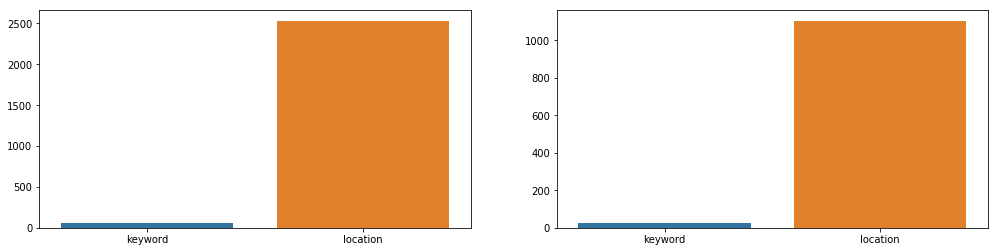

In [8]:
missing_cols = ['keyword','location']

fig,axes = plt.subplots(ncols=2, figsize=(17,4))

sns.barplot(x=train_df[missing_cols].isnull().sum().index, y=train_df[missing_cols].isnull().sum().values,ax=axes[0])
sns.barplot(x=test_df[missing_cols].isnull().sum().index, y=test_df[missing_cols].isnull().sum().values,ax=axes[1])

plt.show()




In [9]:
train_df['keyword'].nunique()

221

In [10]:
train_df['location'].nunique()

3341

Meta Features 


In [11]:
train_df.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [12]:
### Word count 

train_df['word_count'] = train_df['text'].apply(lambda x : len(str(x).split()))
test_df['word_count'] = test_df['text'].apply(lambda x: len(str(x).split()))

In [13]:
### Unique Word Count

train_df['unique_word_count'] = train_df['text'].apply(lambda x : len(set(str(x).split())))
test_df['unique_word_count'] = test_df['text'].apply(lambda x: len(set(str(x).split())))

In [14]:
from wordcloud import STOPWORDS

In [15]:
### Stop Word Count

train_df['stop_word_count'] = train_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test_df['stop_word_count'] = test_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

In [16]:
### Mean word length

train_df['mean_word_length'] = train_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df['mean_word_length'] = test_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [17]:
### Hashtag Count

train_df['hash_tag_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test_df['hash_tag_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

In [18]:
train_df['mention_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test_df['mention_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

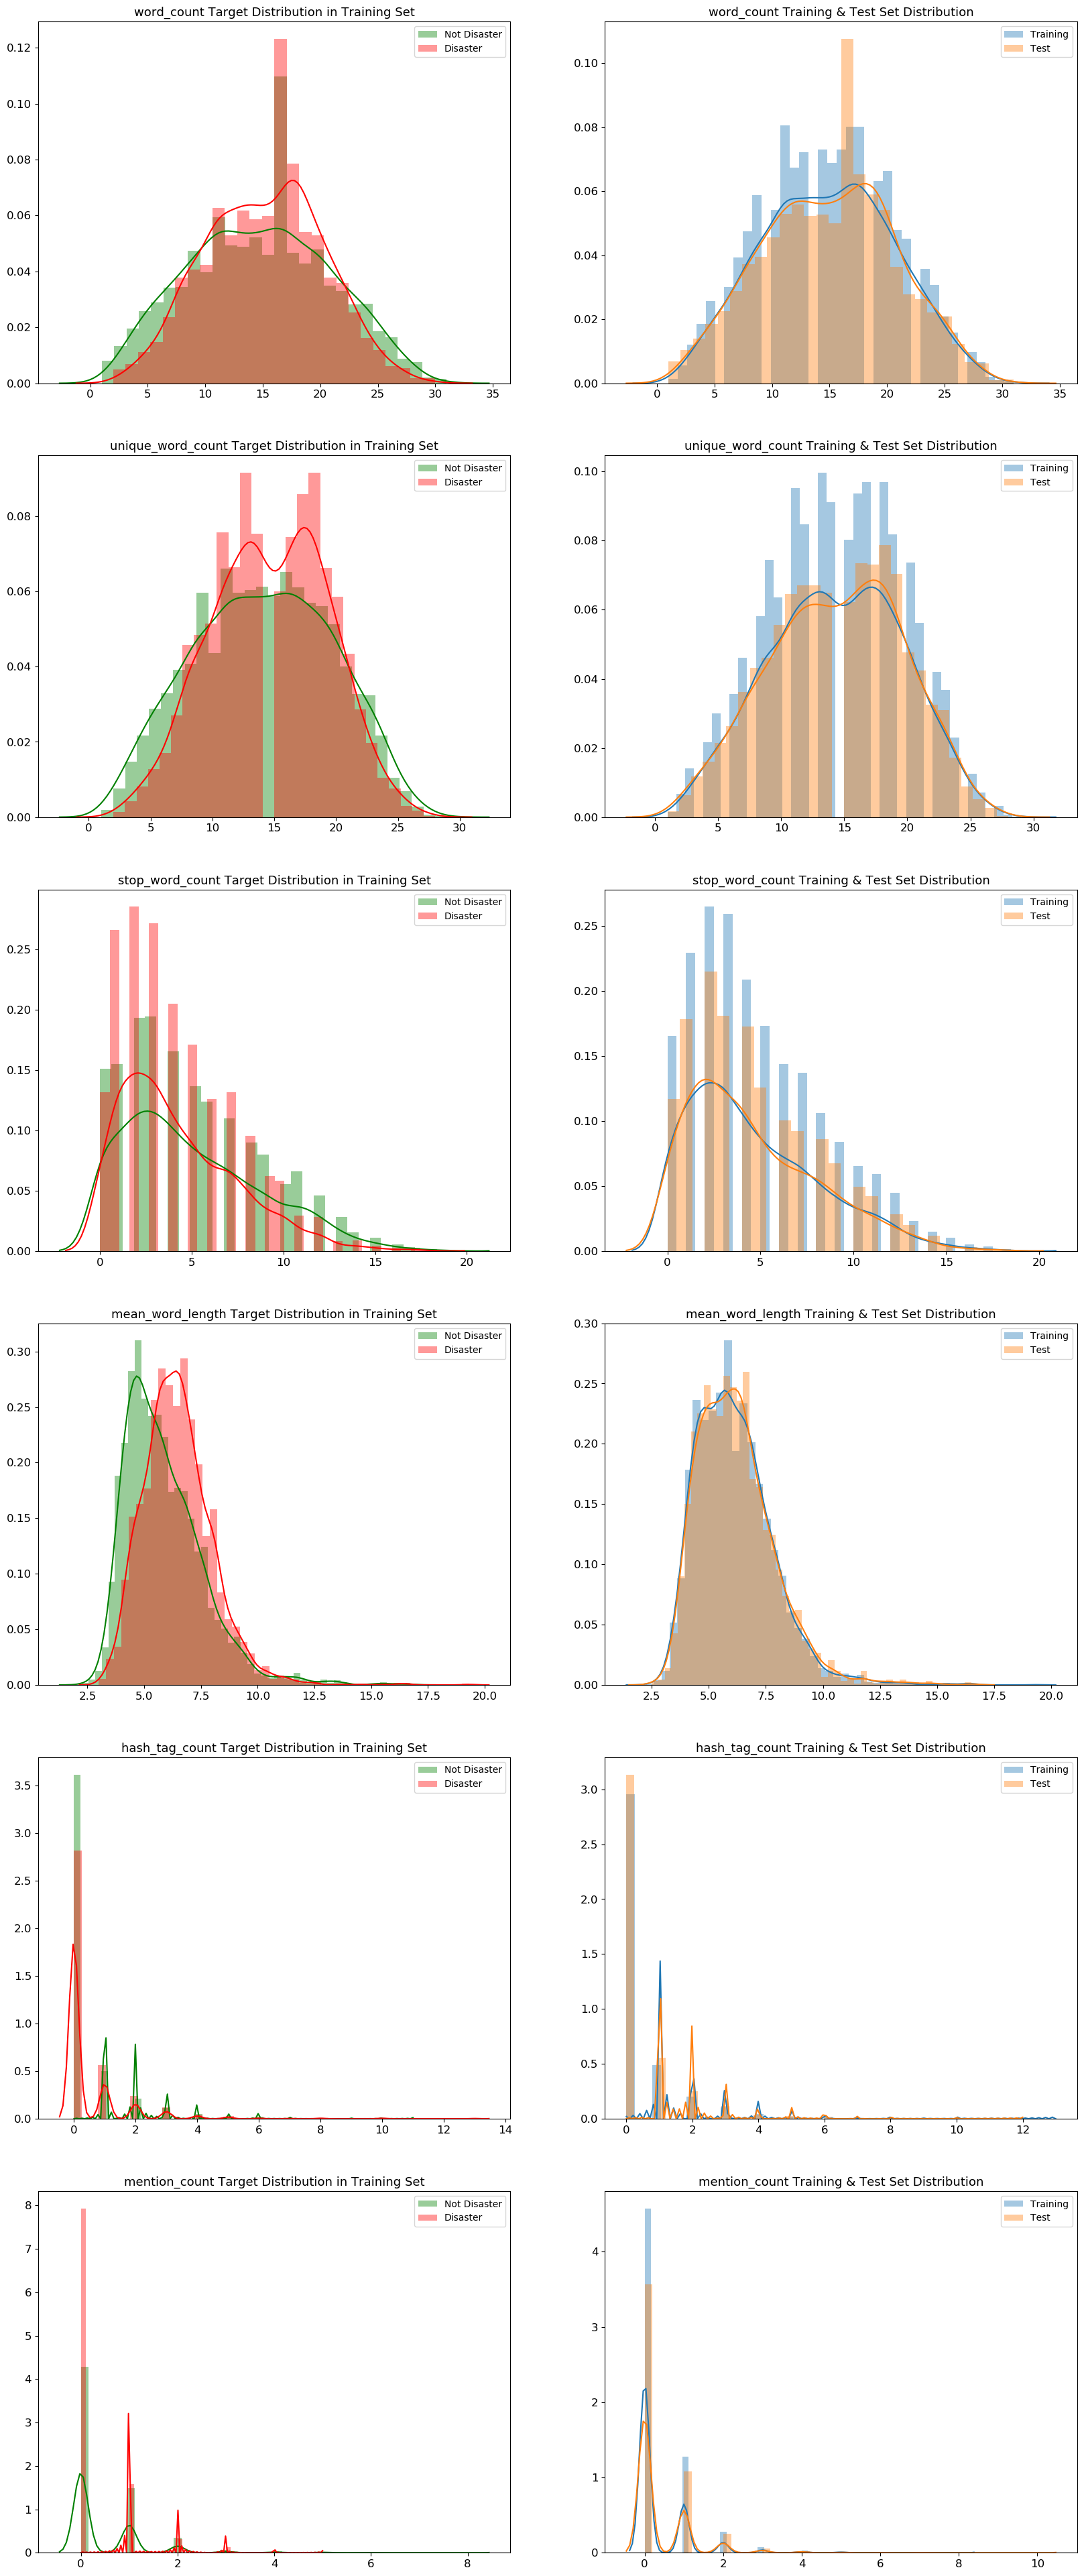

In [19]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'mean_word_length',
                 'hash_tag_count', 'mention_count']
DISASTER_TWEETS = train_df['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(train_df.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(train_df.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(train_df[feature], label='Training', ax=axes[i][1])
    sns.distplot(test_df[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

In [33]:
train_df.groupby('target').count()['id']

target
0    4342
1    3271
Name: id, dtype: int64

classes are almost equally seperated

### Data Cleansing

In [34]:
df = pd.concat([train_df,test_df])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [39]:
import re

In [40]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)



In [41]:
df['text']=df['text'].apply(lambda x : remove_url(x))

### Removing Emojis

In [42]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [43]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))

In [54]:
from tqdm import tqdm
from nltk.tokenize import word_tokenize

In [57]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in STOPWORDS))]
        corpus.append(words)
    return corpus

In [58]:
corpus=create_corpus(df)

100%|██████████| 10876/10876 [00:04<00:00, 2678.15it/s]


In [61]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

Using TensorFlow backend.


In [62]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [63]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 18692


In [64]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 18692/18692 [00:00<00:00, 640695.04it/s]


In [66]:


model = Sequential()
embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [67]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           1869300   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,911,605
Trainable params: 42,305
Non-trainable params: 1,869,300
_________________________________________________________________


In [69]:
train=tweet_pad[:train_df.shape[0]]
test=tweet_pad[train_df.shape[0]:]

In [71]:
X_train,X_test,y_train,y_test=train_test_split(train,train_df['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)


In [74]:
train_df

,id,keyword,location,text,target,word_count,unique_word_count,stop_word_count,mean_word_length,hash_tag_count,mention_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,13,6,4.384615,1,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,7,0,4.571429,0,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,20,11,5.090909,0,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,8,1,7.125000,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,15,7,4.500000,2,0
...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,11,11,2,6.636364,0,0
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,20,17,9,5.300000,0,2
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,8,8,1,7.250000,0,0
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,19,19,5,6.263158,0,0


In [84]:
train = pd.DataFrame(train,index)

In [88]:
train_df.shape

(7613, 11)

In [93]:
train = train.merge(train_df.filter(['word_count','unique_word_count','stop_word_count','mean_word_length','hash_tag_count','mention_count']))

MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False

In [72]:
history=model.fit(X_train,y_train,batch_size=4,epochs=15,validation_data=(X_test,y_test),verbose=2)

Train on 6471 samples, validate on 1142 samples
Epoch 1/15
 - 51s - loss: 0.6910 - accuracy: 0.5676 - val_loss: 0.6869 - val_accuracy: 0.5858
Epoch 2/15
 - 50s - loss: 0.6859 - accuracy: 0.5676 - val_loss: 0.6811 - val_accuracy: 0.5858
Epoch 3/15
 - 51s - loss: 0.6845 - accuracy: 0.5676 - val_loss: 0.6804 - val_accuracy: 0.5858
Epoch 4/15
 - 53s - loss: 0.6846 - accuracy: 0.5676 - val_loss: 0.6803 - val_accuracy: 0.5858
Epoch 5/15
 - 51s - loss: 0.6846 - accuracy: 0.5676 - val_loss: 0.6801 - val_accuracy: 0.5858
Epoch 6/15
 - 52s - loss: 0.6843 - accuracy: 0.5676 - val_loss: 0.6795 - val_accuracy: 0.5858
Epoch 7/15
 - 51s - loss: 0.6843 - accuracy: 0.5676 - val_loss: 0.6797 - val_accuracy: 0.5858
Epoch 8/15
 - 51s - loss: 0.6844 - accuracy: 0.5676 - val_loss: 0.6797 - val_accuracy: 0.5858
Epoch 9/15
 - 50s - loss: 0.6850 - accuracy: 0.5676 - val_loss: 0.6800 - val_accuracy: 0.5858
Epoch 10/15
 - 53s - loss: 0.6846 - accuracy: 0.5676 - val_loss: 0.6799 - val_accuracy: 0.5858
Epoch 11/15

KeyboardInterrupt: 

In [ ]:
sample_sub=pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [ ]:
y_pre=model.predict(test)
y_pre=np.round(y_pre).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
sub.to_csv('submission.csv',index=False)

In [20]:
train_df[train_df["target"] == 0]["text"].values[1]

'I love fruits'

And one that is:

In [21]:
train_df[train_df["target"] == 1]["text"].values[1]

'Forest fire near La Ronge Sask. Canada'

### Building vectors

The theory behind the model we'll build in this notebook is pretty simple: the words contained in each tweet are a good indicator of whether they're about a real disaster or not (this is not entirely correct, but it's a great place to start).

We'll use scikit-learn's `CountVectorizer` to count the words in each tweet and turn them into data our machine learning model can process.

Note: a `vector` is, in this context, a set of numbers that a machine learning model can work with. We'll look at one in just a second.

In [22]:
count_vectorizer = feature_extraction.text.CountVectorizer()

## let's get counts for the first 5 tweets in the data
example_train_vectors = count_vectorizer.fit_transform(train_df["text"][0:5])

In [23]:
## we use .todense() here because these vectors are "sparse" (only non-zero elements are kept to save space)
print(example_train_vectors[0].todense().shape)
print(example_train_vectors[0].todense())

(1, 54)
[[0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0
  0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0]]


The above tells us that:
1. There are 54 unique words (or "tokens") in the first five tweets.
2. The first tweet contains only some of those unique tokens - all of the non-zero counts above are the tokens that DO exist in the first tweet.

Now let's create vectors for all of our tweets.

In [24]:
train_vectors = count_vectorizer.fit_transform(train_df["text"])

## note that we're NOT using .fit_transform() here. Using just .transform() makes sure
# that the tokens in the train vectors are the only ones mapped to the test vectors - 
# i.e. that the train and test vectors use the same set of tokens.
test_vectors = count_vectorizer.transform(test_df["text"])

### Our model

As we mentioned above, we think the words contained in each tweet are a good indicator of whether they're about a real disaster or not. The presence of particular word (or set of words) in a tweet might link directly to whether or not that tweet is real.

What we're assuming here is a _linear_ connection. So let's build a linear model and see!

In [25]:
## Our vectors are really big, so we want to push our model's weights
## toward 0 without completely discounting different words - ridge regression 
## is a good way to do this.
clf = linear_model.RidgeClassifier()

Let's test our model and see how well it does on the training data. For this we'll use `cross-validation` - where we train on a portion of the known data, then validate it with the rest. If we do this several times (with different portions) we can get a good idea for how a particular model or method performs.

The metric for this competition is F1, so let's use that here.

In [26]:
scores = model_selection.cross_val_score(clf, train_vectors, train_df["target"], cv=3, scoring="f1")
scores

array([0.60387232, 0.57511962, 0.64485082])

The above scores aren't terrible! It looks like our assumption will score roughly 0.65 on the leaderboard. There are lots of ways to potentially improve on this (TFIDF, LSA, LSTM / RNNs, the list is long!) - give any of them a shot!

In the meantime, let's do predictions on our training set and build a submission for the competition.

In [27]:
clf.fit(train_vectors, train_df["target"])

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)

In [28]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

In [29]:
sample_submission["target"] = clf.predict(test_vectors)

In [30]:
sample_submission.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1


In [31]:
sample_submission.to_csv("submission.csv", index=False)

Now, in the viewer, you can submit the above file to the competition! Good luck!